Downloads borehole data, interpolates sediment basement to station locations

Generate predictions from Shub's empirical relation

In [1]:
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import seaborn as sns
import pygmt

In [2]:
def delay_to_depth_shubh(tpsb: npt.ArrayLike) -> np.ndarray:
    depth = np.zeros_like(tpsb)
    depth[tpsb < 0.58] = 366 * tpsb[tpsb < 0.58]
    depth[tpsb >= 0.58] = 3206.9 * tpsb[tpsb >= 0.58] - 166.2
    return depth

In [3]:
all_analysis_dir = "/g/data/ha3/am3591/ALL-analysis"
latest_run = max(
    [
        os.path.join(all_analysis_dir, d)
        for d in os.listdir(all_analysis_dir)
        if os.path.isdir(os.path.join(all_analysis_dir, d))
    ],
    key=os.path.getmtime,
)
delaysdf = pd.read_csv(
    os.path.join(latest_run, "delays.txt"),
    sep="\s+",
    names=("Network", "Station", "Longitude", "Latitude", "TPsb"),
)
delaysdf.head()


Network Station  Longitude  Latitude  TPsb
0      1F    CU05   141.2399  -31.2544   0.0
1      1F    CU06   141.0393  -31.8817   0.0
2      1F    CU07   140.9642  -32.3383   0.0
3      1F    CU14   140.4136  -32.2925   0.0
4      1F    CU20   139.8969  -32.3139   0.0

In [4]:
delaysdf["Predicted Depth"] = delay_to_depth_shubh(delaysdf["TPsb"])

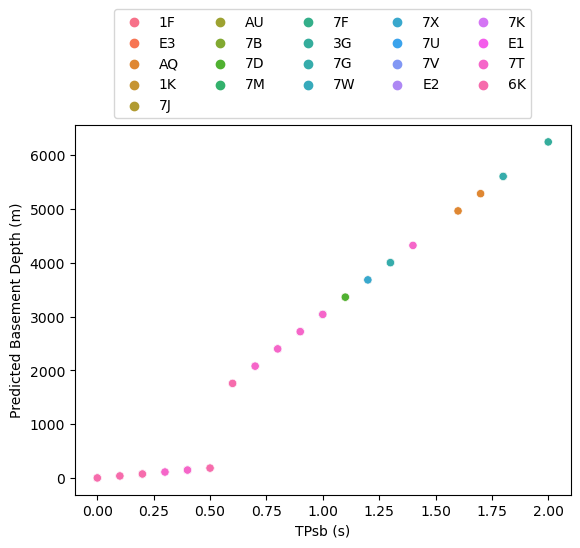

In [5]:
ax = sns.scatterplot(data=delaysdf, x="TPsb", y="Predicted Depth", hue="Network")
ax.set_xlabel("TPsb (s)")
ax.set_ylabel("Predicted Basement Depth (m)")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, ncols=5, loc="lower center", bbox_to_anchor=(0.5, 1))

OZSEABASE data

In [6]:
ln_min, ln_max = (112, 155)
lt_min, lt_max = (-46, -8)
region=[ln_min, ln_max, lt_min, lt_max]

grid = pygmt.xyz2grd(data="/g/data/ha3/am3591/OZSEEBASE2021.xyz", region=[ln_min, ln_max, lt_min, lt_max], spacing=0.0045)
grid *= -1
grid = pygmt.grdclip(grid=grid, above=(15000, 15000), below=(0, 0))

xyz2grd [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
xyz2grd [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
xyz2grd (gmtapi_init_grdheader): Please select compatible -R and -I values


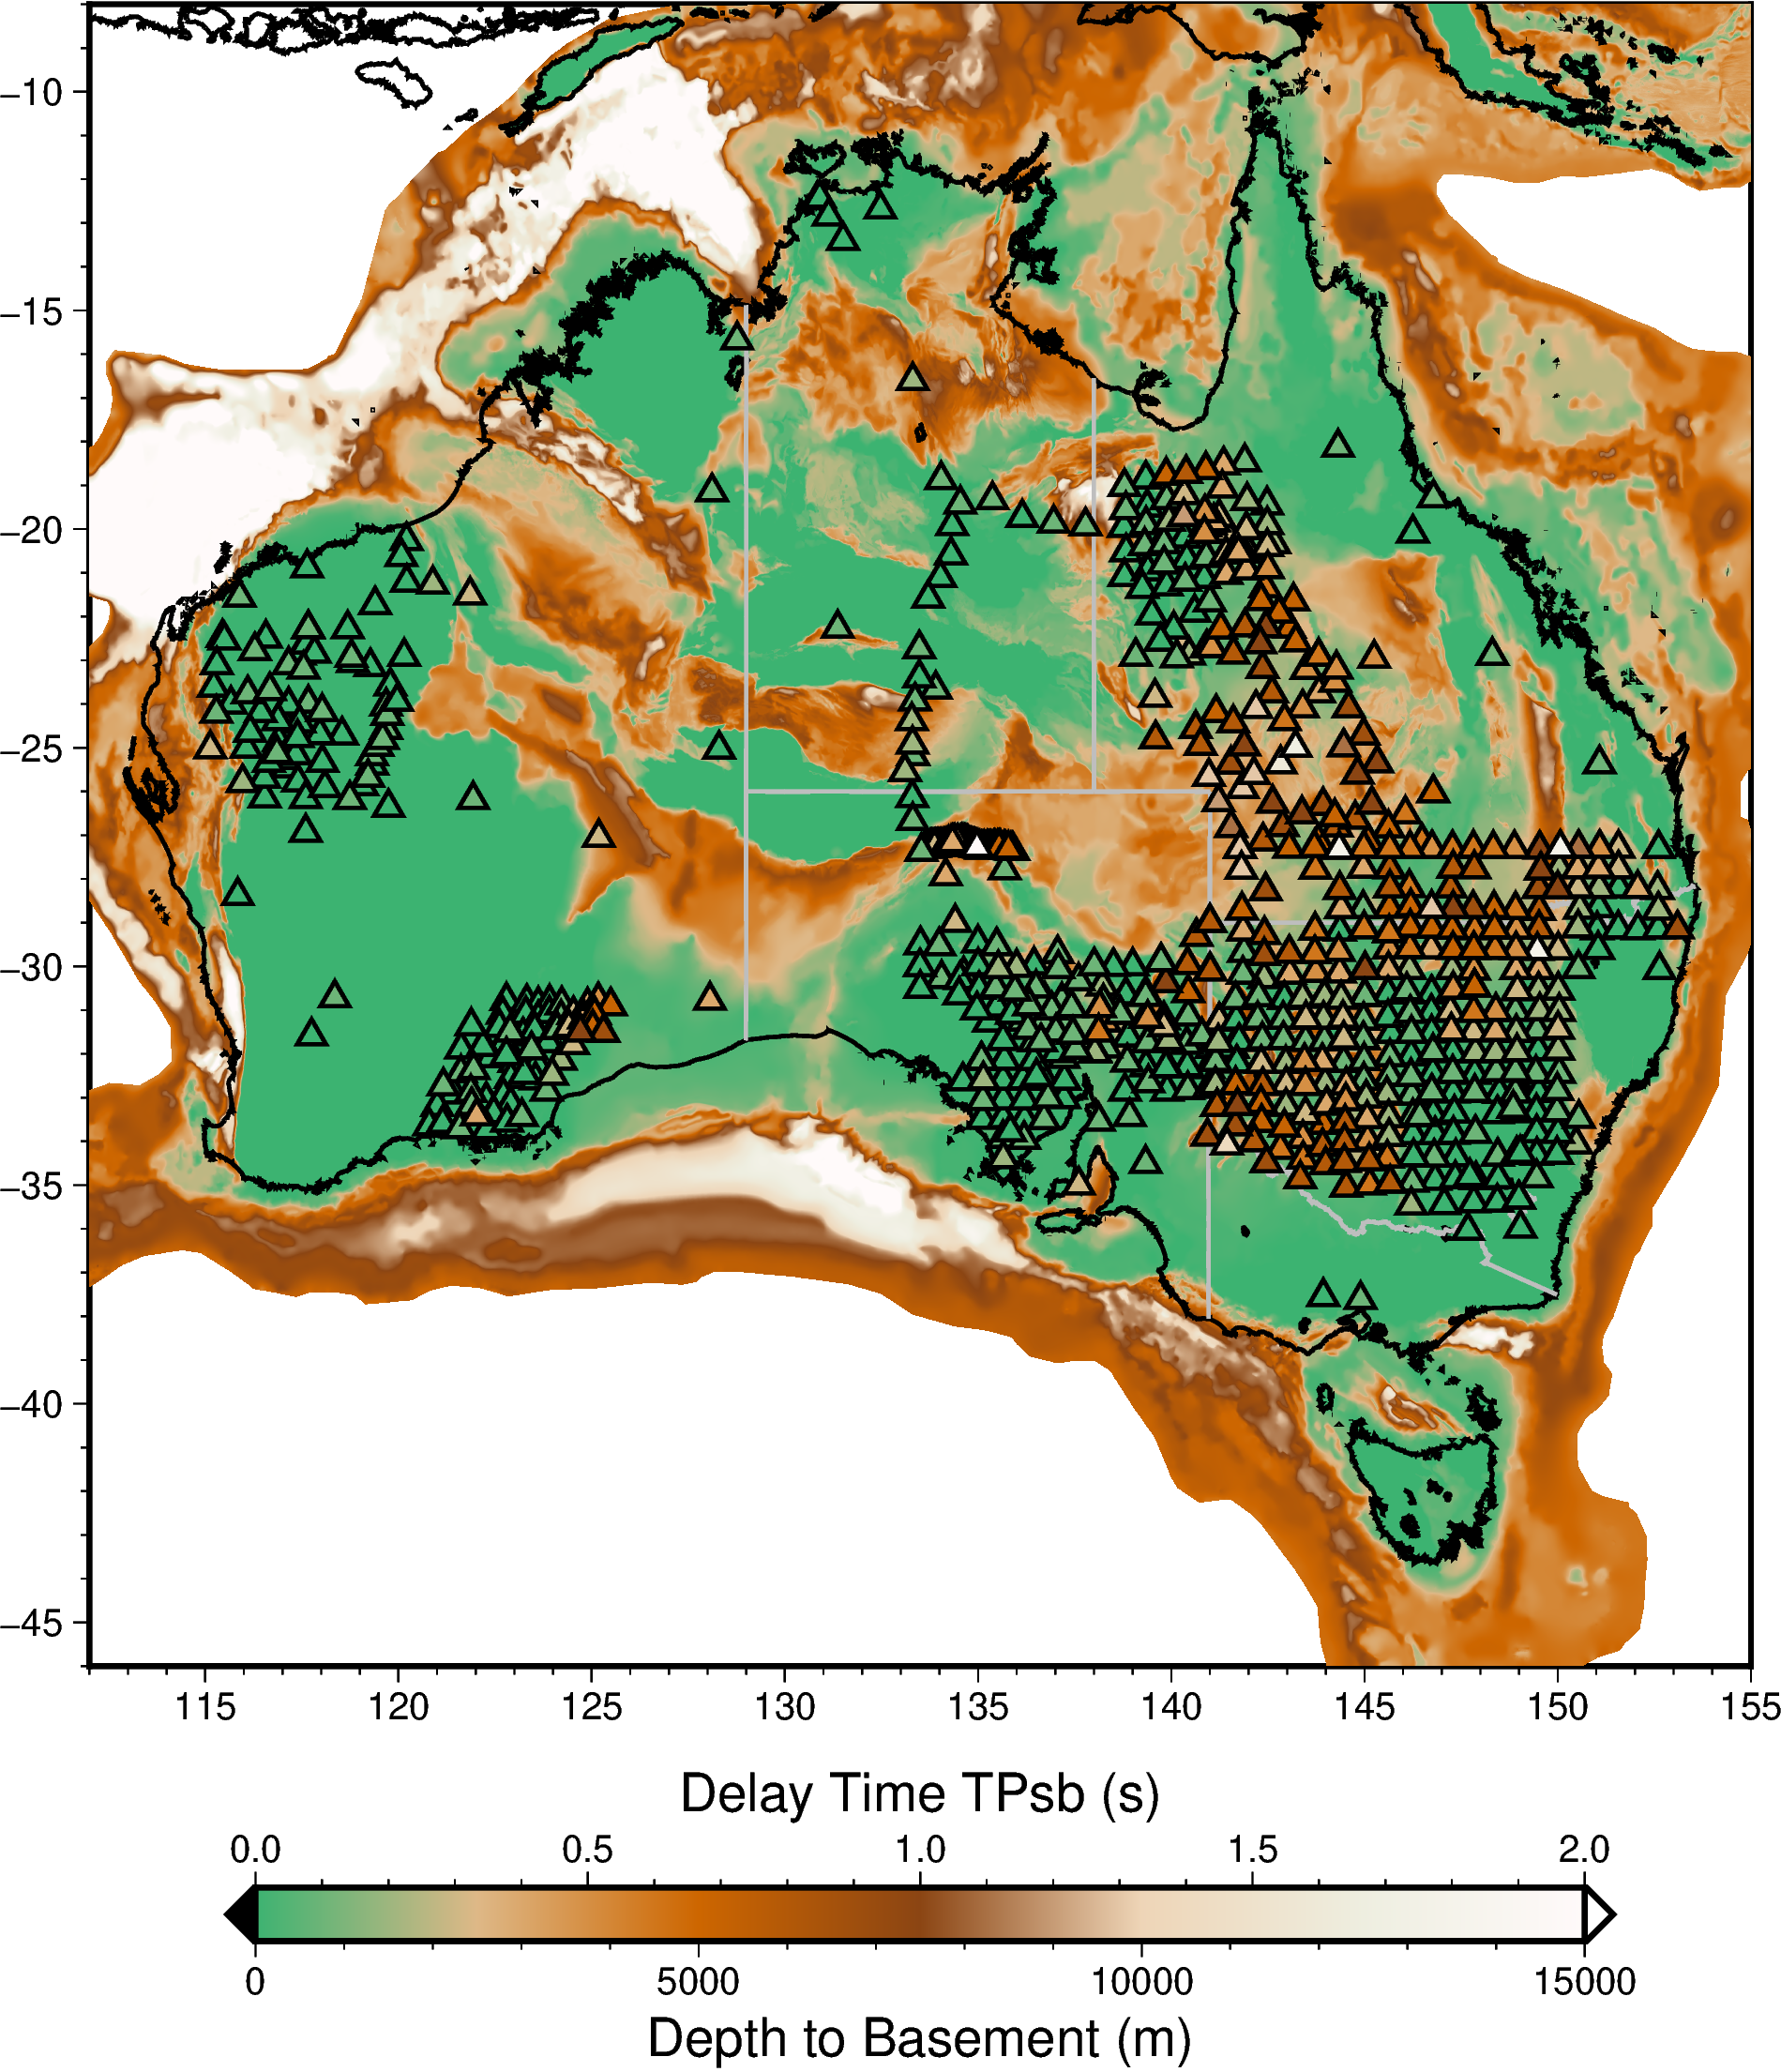

In [7]:
fig = pygmt.Figure()
fig.basemap(region=[ln_min, ln_max, lt_min, lt_max], frame=True)
fig.grdimage(grid=grid, nan_transparent=True, cmap="dem3")
fig.coast(shorelines=1, borders="2/1p,grey")

cbar_position = "JBC+o0/2"
fig.colorbar(frame="af+lDepth to Basement (m)", position=cbar_position)
pygmt.makecpt(cmap="dem3", series=[delaysdf["TPsb"].min(), delaysdf["TPsb"].max()])
fig.plot(
    x=delaysdf["Longitude"],
    y=delaysdf["Latitude"],
    style=f"tc",
    pen="1p",
    fill=delaysdf["TPsb"],
    cmap=True,
    size=np.full_like(delaysdf["Longitude"], 0.3),
)
fig.colorbar(frame="af+lDelay Time TPsb (s)", position=f"{cbar_position}+e+mal")
fig.show()

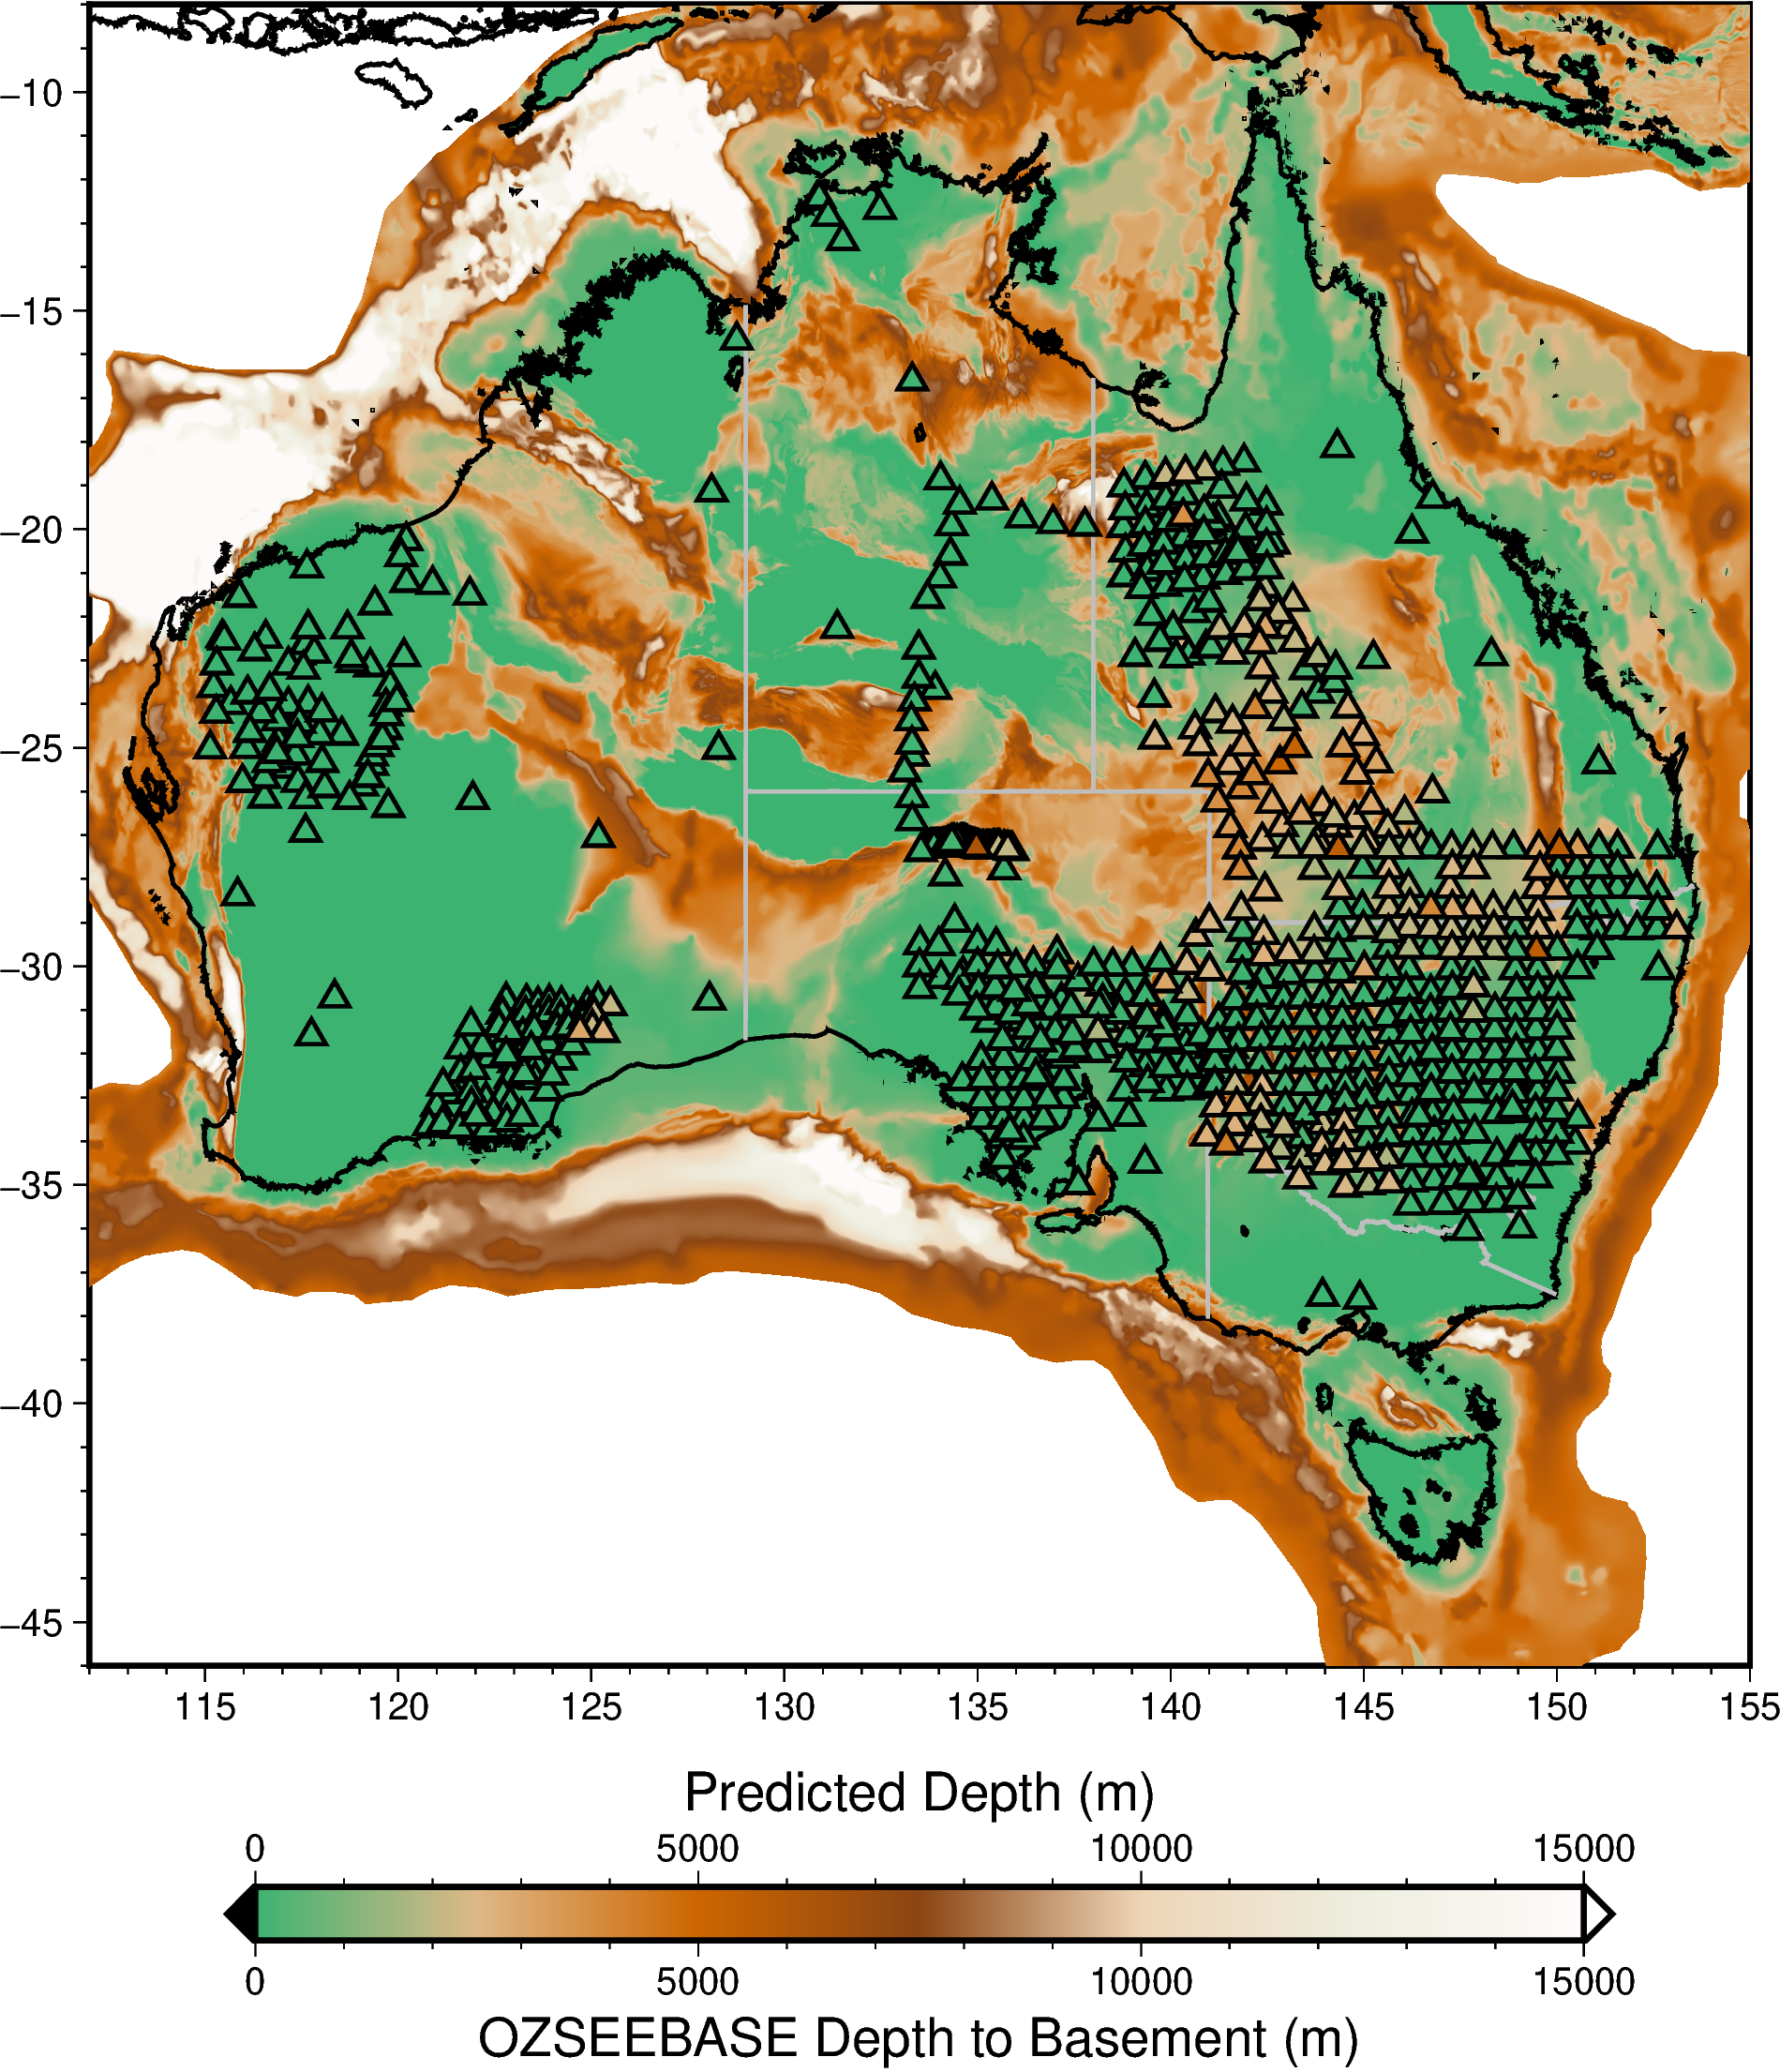

In [8]:
fig = pygmt.Figure()
fig.basemap(region=[ln_min, ln_max, lt_min, lt_max], frame=True)
fig.grdimage(grid=grid, nan_transparent=True, cmap="dem3")
fig.coast(shorelines=1, borders="2/1p,grey")

cbar_position = "JBC+o0/2"
fig.colorbar(frame="af+lOZSEEBASE Depth to Basement (m)", position=cbar_position)
pygmt.makecpt(cmap="dem3", series=[0, 15000])
fig.plot(
    x=delaysdf["Longitude"],
    y=delaysdf["Latitude"],
    style=f"tc",
    pen="1p",
    fill=delaysdf["Predicted Depth"],
    cmap=True,
    size=np.full_like(delaysdf["Longitude"], 0.3),
)
fig.colorbar(frame="af+lPredicted Depth (m)", position=f"{cbar_position}+e+mal")
fig.show()

Assuming OZSEEBASE is already densely sampled enough, get the basement depth at each station (just take nearest sample)

In [12]:
coordinates = np.array(np.meshgrid(grid.x, grid.y)).T.reshape((-1,2))

In [19]:
from scipy.spatial import KDTree
distance,index = KDTree(coordinates).query(delaysdf[["Longitude", "Latitude"]].values)

In [44]:
delaysdf["OZSEEBASE Depth"] = pd.Series([grid.sel(x=coordinates[i, 0], y=coordinates[i, 1]).values for i in index]).astype(float)

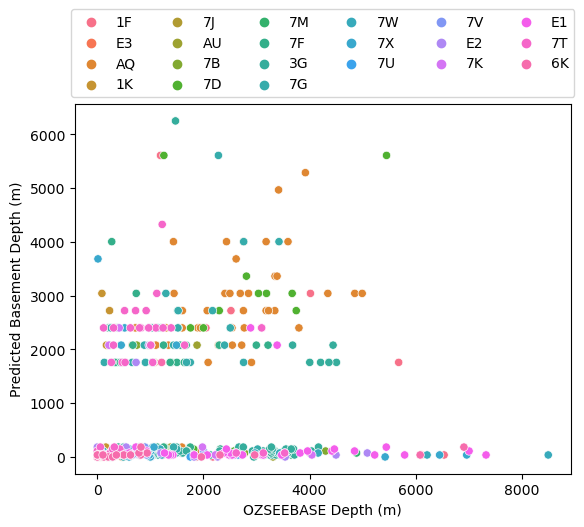

In [47]:
ax = sns.scatterplot(data=delaysdf, x="OZSEEBASE Depth", y="Predicted Depth", hue="Network")
ax.set_xlabel("OZSEEBASE Depth (m)")
ax.set_ylabel("Predicted Basement Depth (m)")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, ncols=6, loc="lower center", bbox_to_anchor=(0.5, 1))